# Init

In [1]:
! pip install qrcode -q
! pip install insightface -q
! pip install onnxruntime -q

In [2]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import requests  
import json  
import random
import qrcode

In [4]:
gen_image = 'gen.png'
gen_image_hosted = 'gen_hosted.png'
qr_image = 'qr.png'
output_image = 'output.png'
webcam_image = 'webcam.jpeg'

# Step 1: Image generation

## Step 1-1: Using Paid API

In [5]:
url =  "https://stablediffusionapi.com/api/v4/dreambooth"  

options_character = ["a man", "a woman", "a female doll", "a male doll", "a female warrior", "a prince",
                    "a princess", "a man in suit", "a woman in suit", "a male mermaid", "a cyborg",
                    "a robot", "a fairy", "a male fairy", "a male astronaut", "a female astronaut", "a female steampunk inventor", 
                    "a male steampunk inventor", "a crazy scientist", "a mafia man", "a space sailor", "a male climate engineer", "a female climate engineer",
                    "a male space farmer", "a female space farmer", "a time traveler", "a wizard", "a witch", "a male explorer", "a female explorer",
                    "AI Mechanic", 'female AI mechanic' "a robot bride", "a robot groom", "a barbie doll", "a Ken doll"]

options_location = ['in the forest', 'in front of a neon building', 'in the steampunk factory', 'in the heaven', 'in the hell', 'in the space ship', 'in the space', 'in the colorful barbie world',
                    'in the magnificent palace','in front of a luxurious palace', 'in the dynamic ocean world', 'in the underground world', 'in the colorful aquarium', 'in a garden surrounded by alien plants', 
                    'in a space farm','in a snowy world', 'in fire world', 'in a ruin', 'in forest fire', "in front of a cyberpunk portal", 'on a music planet', 'in black hole', 
                    'in a magic cave', 'in colorful galaxy', 'in front of a supernova', 'in northpole', 'in an ice palace', 'in a cybepunk city', 'in a steampunk city',
                    'a smoky dragon island', 'in Hogwarts', 'in front of an exploding nuclear bomb', "in a riot", 'in a battlefield', 'in pure chaos', 'in a desert',
                    'in a stardust night', 'in the rain', 'in front a waterfall', 'a floating flower world', 'in a colorful crystal cave', 'in a volcano'
                   ]

In [6]:
# choose a random 
option1 = random.choice(options_character)
option2 = random.choice(options_location)

# 替换字符串
prompt = "in location, a person, alone, facing the camera, solo, skin detail, face detail, Taiwanese, raw photo ,8K HDR, hyper-realistic, half body shot, hyper detailed, cinematic lighting"
prompt = prompt.replace("a person", option1).replace("in location", option2)
neg_prompt = "nsfw, nude, censored, ((duplication)), more than one person, text, watermark, blurry background, naked, half naked, topless, wearing underwear, showing thighs, showing chest, deformed iris, deformed pupils, out of frame, cropped, not wearing pants,semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation, worst quality, normal quality, low quality, low res, blurry, text, watermark, logo, banner, extra digits, cropped, jpeg artifacts, signature, username, error, sketch ,duplicate, ugly, monochrome, horror, geometry, mutation, disgusting, bad anatomy, bad hands, three hands, three legs, bad arms, missing legs, missing arms, poorly drawn face, bad face, fused face, cloned face, worst face, three crus, extra crus, fused crus, worst feet, three feet, fused feet, fused thigh, three thigh, fused thigh, extra thigh, worst thigh, missing fingers, extra fingers, ugly fingers, long fingers, horn, extra eyes, huge eyes, 2girl, amputation, disconnected limbs, cartoon, cg, 3d, unreal, animate"

In [7]:
payload = json.dumps({  
    "key":  "7v70nMZ61AbixLzjyBXGZEKIPyDimkwhajobxeVD1vZRE3kLDyNVbQypfkR0",  
    "model_id":  "realistic-vision-v51",  
    "prompt": prompt,
    "negative_prompt": neg_prompt,
    "width":  "1024",  
    "height":  "1024",  
    "samples":  "1",  
    "num_inference_steps":  "55",  
    "safety_checker":  "no",  
    "restore_faces": "yes" ,
    "enhance_prompt":  "yes",  
    "seed":  -1,  
    "guidance_scale":  7.5,  
    "multi_lingual":  "no",  
    "panorama":  "no",  
    "self_attention":  "no",  
    "upscale":  "no",  
    "sampler_index": "DPM++ 2M Karras",
    "embeddings":  "embeddings_model_id",  
    "lora":  "lora_model_id",  
    })  
  
headers =  {  
'Content-Type':  'application/json'  
}  

response = requests.request("POST", url, headers=headers, data=payload)  
print(prompt)

response.text
response_dict = json.loads(response.text)

# check if the status is "processing"
if response_dict['status'] == "success":
    print("加載成功")
    output_list = response_dict.get('output', [])
    
    if output_list and isinstance(output_list[0], str):
        image_url = output_list[0].split('"')[0]
        cleaned_url = image_url.replace('\\', '')
        
        print("圖片網址:", cleaned_url)

else:
    print("加載失敗")

in northpole, a woman in suit, alone, facing the camera, solo, skin detail, face detail, Taiwanese, raw photo ,8K HDR, hyper-realistic, half body shot, hyper detailed, cinematic lighting
加載成功
圖片網址: https://cdn2.stablediffusionapi.com/generations/0-774dfdd4-1407-4cd5-864f-d9dab687d5fe.png


In [8]:
payload = json.dumps({  
    "key":  "7v70nMZ61AbixLzjyBXGZEKIPyDimkwhajobxeVD1vZRE3kLDyNVbQypfkR0",  
    "model_id":  "realistic-vision-v51",  
    "prompt": prompt,  
    "negative_prompt": neg_prompt , 
    "width":  "1024",  
    "height":  "1024",  
    "samples":  "1",  
    "num_inference_steps":  "55",  
    "safety_checker":  "no",  
    "enhance_prompt":  "yes",  
    "seed":  -1,  
    "guidance_scale":  7.5,  
    "multi_lingual":  "no",  
    "panorama":  "no",  
    "self_attention":  "no",  
    "upscale":  "no",  
    "embeddings":  "embeddings_model_id",  
    "lora":  "lora_model_id",  
    "webhook":  None,  
    "track_id":  None  
})  
  
headers =  {  
'Content-Type':  'application/json'  
}  

response = requests.request("POST", url, headers=headers, data=payload)  
print(prompt)

response.text
response_dict = json.loads(response.text)

# check if the status is "processing"
if response_dict['status'] == "success":
    print("加載成功")
    output_list = response_dict.get('output', [])
    
    if output_list and isinstance(output_list[0], str):
        image_url = output_list[0].split('"')[0]
        cleaned_url = image_url.replace('\\', '')
        
        print("圖片網址:", cleaned_url)

else:
    print("加載失敗")

in northpole, a woman in suit, alone, facing the camera, solo, skin detail, face detail, Taiwanese, raw photo ,8K HDR, hyper-realistic, half body shot, hyper detailed, cinematic lighting
加載成功
圖片網址: https://cdn2.stablediffusionapi.com/generations/0-1090a0ba-4de3-4729-9207-84d7217868fa.png


In [9]:
# response.text
# response_dict = json.loads(response.text)

# # check if the status is "processing"
# if response_dict['status'] == "processing":
#     print("圖片仍在加載中")
# elif response_dict['status'] == "success":
#     print("加載成功")
#     output_list = response_dict.get('output', [])
    
#     if output_list and isinstance(output_list[0], str):
#         image_url = output_list[0].split('"')[0]
#         cleaned_url = image_url.replace('\\', '')
        
#         print("圖片網址:", cleaned_url)

# else:
#     print("加載失敗")

In [10]:
response = requests.get(cleaned_url, stream=True)
response.raise_for_status()

# Open a local file with wb (write binary) permission.
with open(gen_image, 'wb') as out_file:
    # Write the content of the image to the file.
    for chunk in response.iter_content(8192):
        out_file.write(chunk)

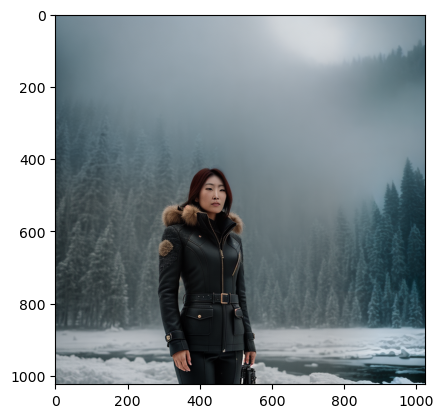

In [11]:
# Open an image file
image_path = gen_image
with Image.open(image_path) as image:
    bg_img = np.array(image)

plt.imshow(bg_img)

faces =app.get(bg_img)
len(faces)

## Step 1-2: Using hosted API

In [12]:
def submit_post(url: str, data: dict):
    """
    Submit a POST request to the given URL with the given data.
    """
    return requests.post(url, data=json.dumps(data))

In [13]:
# generate image by using nccu server

txt2img_url = "http://140.119.112.78:8827/"
data = {
            "modelInputs": {
                "prompt": prompt,
                "negative_prompt": neg_prompt,
                "num_inference_steps": 100,
                "guidance_scale": 7.5,
                "width": 1024,
                "height": 1024,
                "seed": 323902207
            },
            "callInputs": {
                "MODEL_ID": "stablediffusionapi/realistic-vision-51",
                "PIPELINE": "StableDiffusionPipeline",
                "SCHEDULER": "LMSDiscreteScheduler",
                "safety_checker": "true"
            }
        }



In [14]:
import time

# while True:
#     response = submit_post(txt2img_url, data)

#     if '$error' not in json.loads(response.text):
#         print("success")
#         break  # Exit the loop if user enters 'exit'
#     else:
#         print('failed')
        
#     time.sleep(1)

In [15]:
import base64
from io import BytesIO

# image_hosted = response.json()['image_base64']

# with open(gen_image_hosted, "wb") as image_file:
#         image_file.write(base64.b64decode(image_hosted))
        
        
# # Open an image file
# image_path = gen_image_hosted
# with Image.open(image_path) as image:
#     temp = np.array(image)

# plt.imshow(temp)


## Step 1-3: Using Webui API

In [16]:
url = 'http://140.119.112.78:8824/sdapi/v1/txt2img'

In [17]:
data = {'prompt': prompt,
        "negative_prompt": neg_prompt,
        "sampler_name": "DPM++ 2M Karras",
        'width': 1024,
        'height': 1024}

In [ ]:
while True:
    response = submit_post(url, data)

    if '$error' not in json.loads(response.text):
        print("success")
        break  # Exit the loop if user enters 'exit'
    else:
        print('failed')
        
    time.sleep(1)

In [ ]:
image_hosted = response.json()['images'][0]

with open(gen_image_hosted, "wb") as image_file:
        image_file.write(base64.b64decode(image_hosted))
        
        
# Open an image file
image_path = gen_image_hosted
with Image.open(image_path) as image:
    temp = np.array(image)

plt.imshow(temp)


In [ ]:
# response_dict = json.loads(response.text)
# image_url = response_dict['output'][0]
# cleaned_url = image_url.replace('\\', '')
# cleaned_url

In [ ]:
# # url = json.loads(response.text)['output'][0]
# url = "https://cdn2.stablediffusionapi.com/generations/0-edcd047e-e585-4864-8c1e-71137c2aa1bc.png"
# url

In [ ]:
# response = requests.get(url, stream=True)
# response.raise_for_status()

# # Open a local file with wb (write binary) permission.
# with open(gen_image, 'wb') as out_file:
#     # Write the content of the image to the file.
#     for chunk in response.iter_content(8192):
#         out_file.write(chunk)

# Step 2: Swap face

In [ ]:
# import cv2
# import numpy as np
# import insightface
# from insightface.app import FaceAnalysis
# from insightface.data import get_image as ins_get_image
# from PIL import Image
# import matplotlib.pyplot as plt

In [ ]:
# !pip install --upgrade numpy

In [ ]:
# print('insightface', insightface.__version__)
# print('numpy', np.__version__)

## 2-1 Detect face

In [ ]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

# Open an image file
image_path = gen_image_hosted
with Image.open(image_path) as image:
    bg_img = np.array(image)

plt.imshow(bg_img)

In [ ]:
faces =app.get(bg_img)

In [ ]:
# import random
# import json
# import requests

# # Your existing options_character and options_location lists

# # ... (rest of the code)

# # Check the length of faces
# if len(faces) > 1:
#     # Choose a random character option and location option
#     option1 = random.choice(options_character)
#     option2 = random.choice(options_location)
    
#     # Replace strings in the prompt
#     prompt = "raw photo, detailed-background, a person, Taiwanese, a realshot photograph, standing in location, hyper-realistic, skin pores, (skin detail: 1.2), close up, (wearing pants), facial detail, half body shot, illustration, hyper-detailed, (epic background), epic, intricate, hyper detailed, art station, concept art, smooth, sharp focus, ray tracing, colorful"
#     prompt = prompt.replace("a person", option1).replace("standing in location", option2)
    
#     # ... (rest of the payload and request code)
#     # Make sure to keep the rest of the code intact
    
#     response = requests.request("POST", url, headers=headers, data=payload)
#     print(prompt)
# else:
#     print("No need to rerun the code.")


In [ ]:
face_on_bg = app.get(bg_img)[0]

bbox = face_on_bg['bbox']
bbox = [int(b) for b in bbox]
plt.imshow(bg_img[bbox[1]:bbox[3],
                  bbox[0]:bbox[2],
                  ::-1])

## 2-2 Swap face

In [ ]:
swapper = insightface.model_zoo.get_model('inswapper_128.onnx',
                                          download=False,
                                          download_zip=False)

In [ ]:
# Open an image file
image_path = webcam_image
with Image.open(image_path) as image:
    face_from_webcam = np.array(image)
    
    
plt.imshow(face_from_webcam)
face_from_webcam = app.get(face_from_webcam)[0]


In [ ]:
output = swapper.get(bg_img, face_on_bg, face_from_webcam, paste_back=True)

In [ ]:
output_filename = output_image

# Convert ndarray to an Image object
image = Image.fromarray(output)

# Save the image
image.save(output_filename)


plt.imshow(output)

# Step 3

In [ ]:
url = "http://140.119.112.78:8823/lab/tree/work/CID/" + output_image
# url = "https://b42a.myqnapcloud.com/share.cgi?tunnel_agent_id=60cb61cda1c19d7d2f5c0f5a&func=get_thumb&ssid=a92b1c85a77840e1858c26b61b63bbd2&access_token=2.wX3yAxbnXO4asGBHPDpLfV6oY82Tfq2KssYASQPA.1692580720&fid=a92b1c85a77840e1858c26b61b63bbd2&path=%2F&size=640&name={}&cacheSlayer=766567.895074163".format(output_filename)
# url = "https://www.myqnapcloud.com/smartshare/72ff17jlj1n32r2t9x4w1b8y_a60e1h08i23529s2082v83x51a86deh9"

In [ ]:
qr_img = qrcode.make(url)
plt.imshow(qr_img)